In [3]:
# !pip install statsmodels
# !pip install hyperopt

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, anneal, Trials

from statsmodels.tsa.seasonal import seasonal_decompose

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import xgboost as xgb
from xgboost import XGBRegressor



In [5]:
# load dataset

outbound_data = pd.read_csv('outbound_data.csv', low_memory=False)

outbound_data.head()

,Order_date,T_Nb_of_pallets,Nb_of_colli,Time(hrs),Total_Nb_Pallet,Number_of_orders,Order_frequency,Month,Day,Week,Quarter
0,03-01-2023,47.0,3358.0,264.00,114.0,817,high,1,3,1,1
1,06-01-2023,470.0,2451.0,436.37,519.0,536,medium,1,6,1,1
2,07-01-2022,279.0,5757.0,517.05,394.0,406,medium,1,7,1,1
3,12-01-2022,220.0,2540.0,297.98,271.0,523,medium,1,12,2,1
4,01-02-2023,323.0,3396.0,413.70,391.0,809,high,2,1,5,1


In [6]:
# outbound_data['Nb_of_colli'].max()

# Convert 'Order_date' to datetime format
outbound_data['Order_date'] = pd.to_datetime(outbound_data['Order_date'], format='%d-%m-%Y')

# Sort DataFrame by 'Order_date'
outbound_data = outbound_data.sort_values('Order_date')
outbound_data

,Order_date,T_Nb_of_pallets,Nb_of_colli,Time(hrs),Total_Nb_Pallet,Number_of_orders,Order_frequency,Month,Day,Week,Quarter
2,2022-01-07,279.0,5757.0,517.05,394.0,406,medium,1,7,1,1
3,2022-01-12,220.0,2540.0,297.98,271.0,523,medium,1,12,2,1
8,2022-02-08,224.0,2201.0,274.62,268.0,8,low,2,8,6,1
9,2022-02-09,246.0,4543.0,502.98,337.0,3,low,2,9,6,1
10,2022-02-11,161.0,3050.0,296.07,222.0,2,low,2,11,6,1
...,...,...,...,...,...,...,...,...,...,...,...
172,2023-07-25,146.0,2570.0,261.77,197.0,919,high,7,25,30,3
181,2023-07-26,57.0,1499.0,144.60,87.0,608,high,7,26,30,3
190,2023-07-27,66.0,3108.0,236.93,128.0,1385,high,7,27,30,3
199,2023-07-28,119.0,1814.0,199.14,155.0,727,high,7,28,30,3


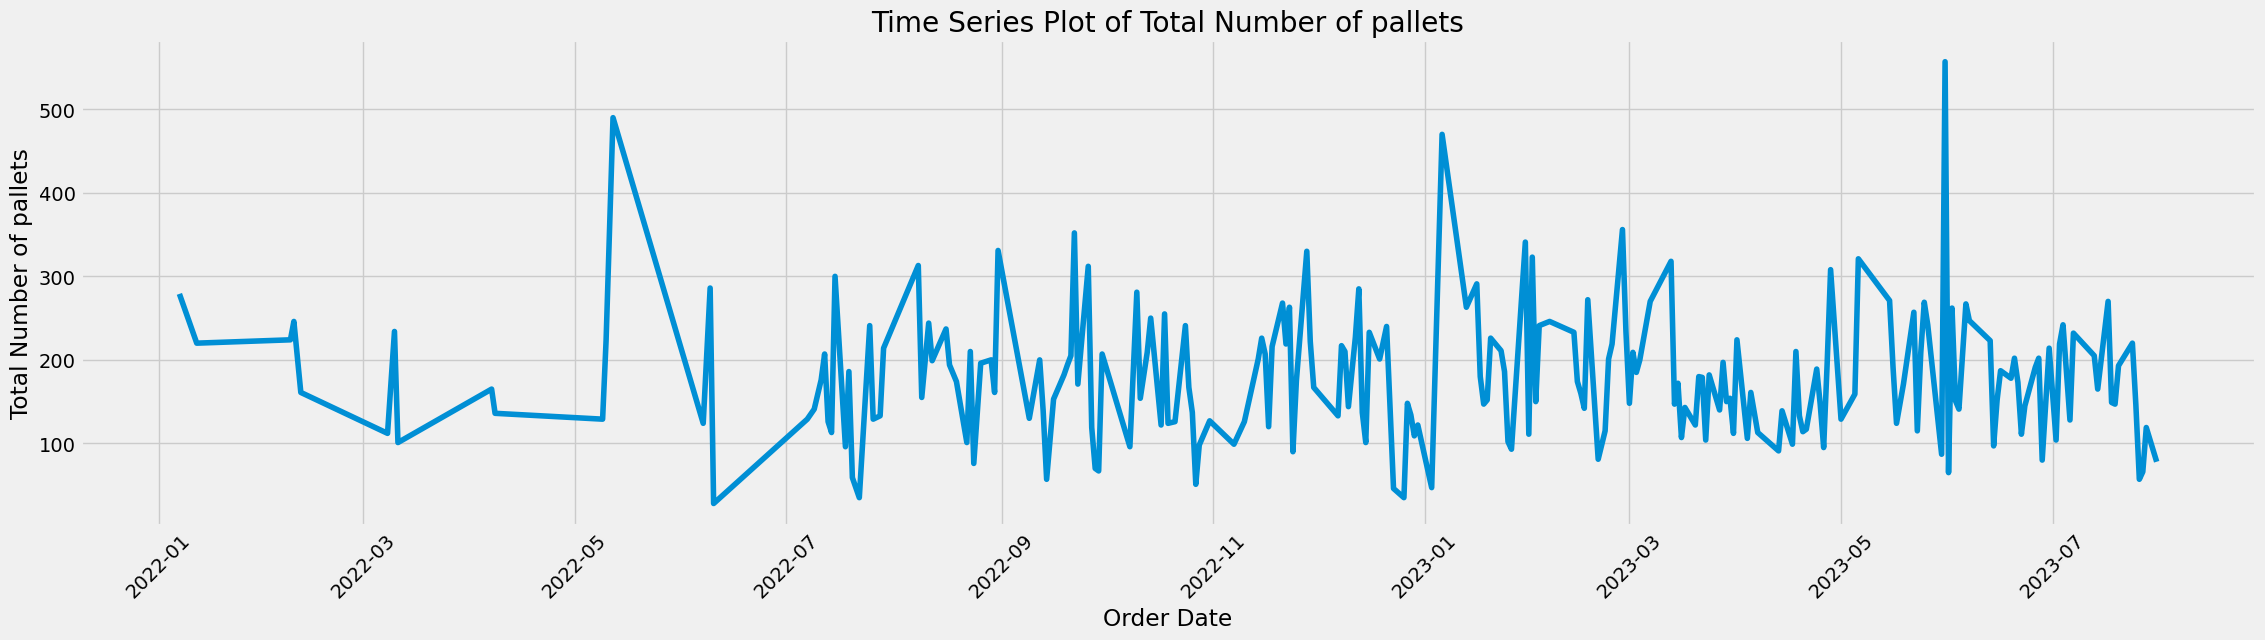

In [7]:
plt.figure(figsize=(25, 6))
plt.plot(outbound_data['Order_date'], outbound_data['T_Nb_of_pallets'], linestyle='-')
plt.title('Time Series Plot of Total Number of pallets')
plt.xlabel('Order Date')
plt.ylabel('Total Number of pallets')
plt.xticks(rotation=45) 
plt.show()

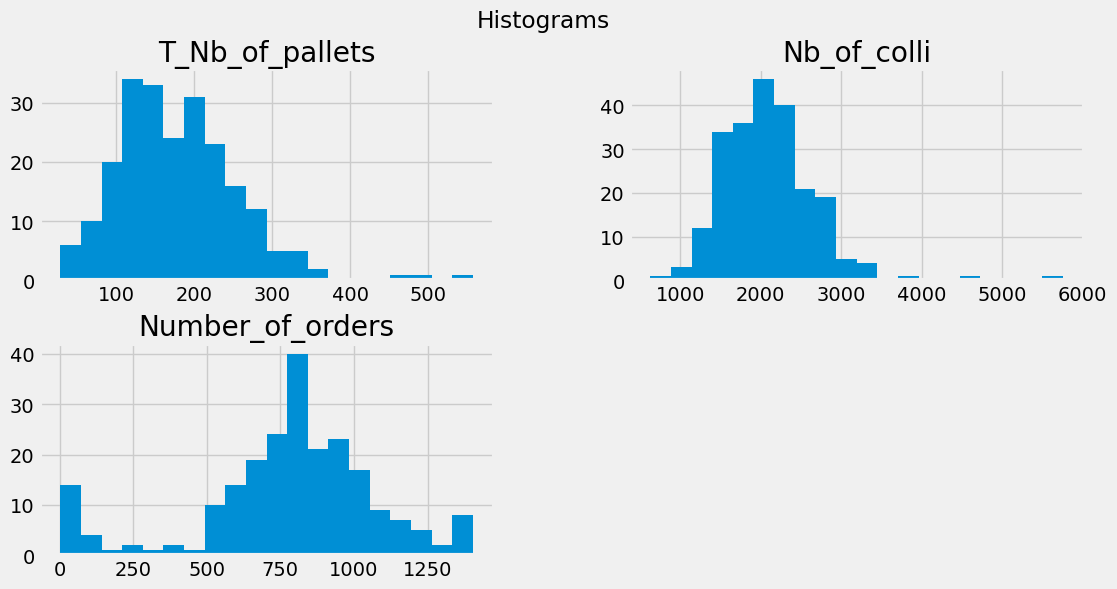

In [8]:
# Histograms
outbound_data[['T_Nb_of_pallets', 'Nb_of_colli', 'Number_of_orders']].hist(figsize=(12, 6), bins=20)
plt.suptitle('Histograms')
plt.show()

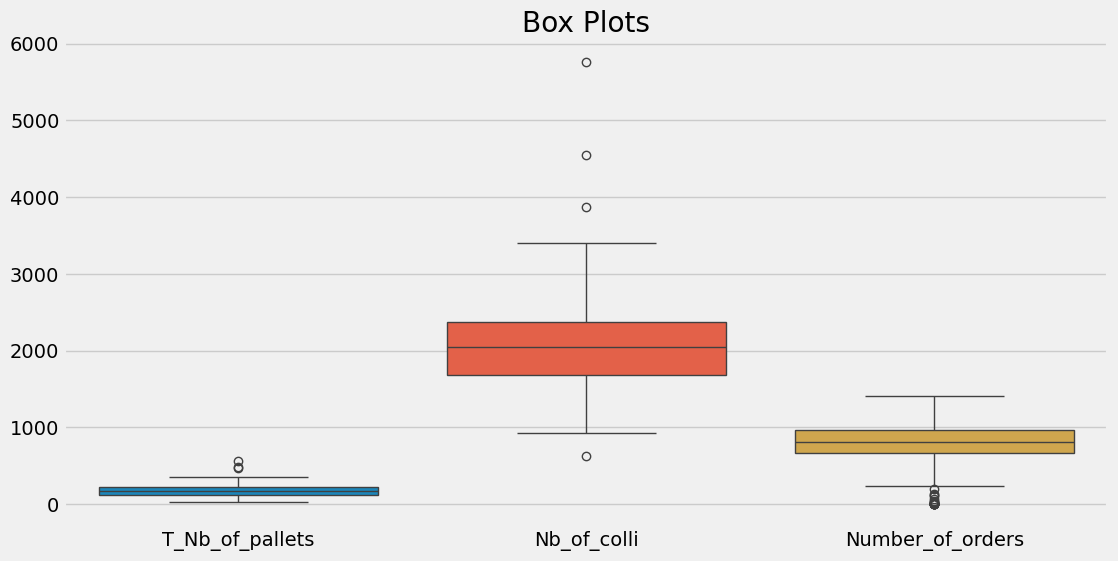

In [145]:
# Box Plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=outbound_data[['T_Nb_of_pallets', 'Nb_of_colli', 'Number_of_orders']])
plt.title('Box Plots')
plt.show()

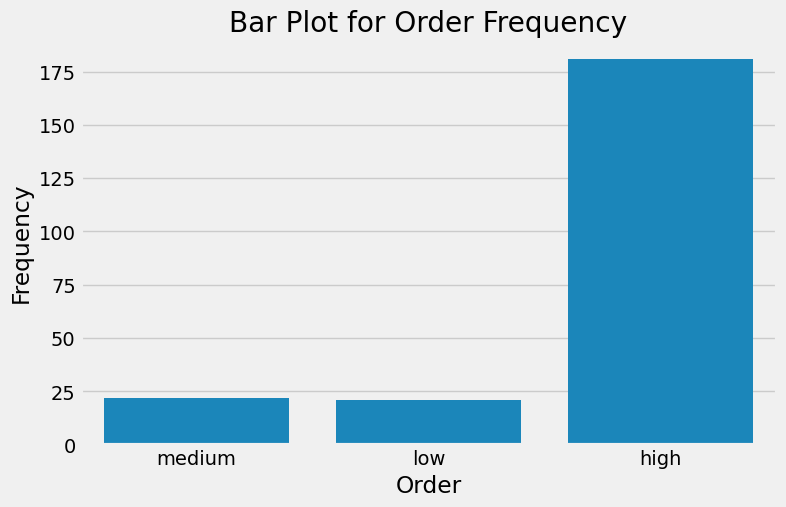

In [147]:
# Bar Plot for Categorical Data
plt.figure(figsize=(8, 5))
sns.countplot(x='Order_frequency', data=outbound_data)
plt.title('Bar Plot for Order Frequency')
plt.xlabel('Order')
plt.ylabel('Frequency')
plt.show()


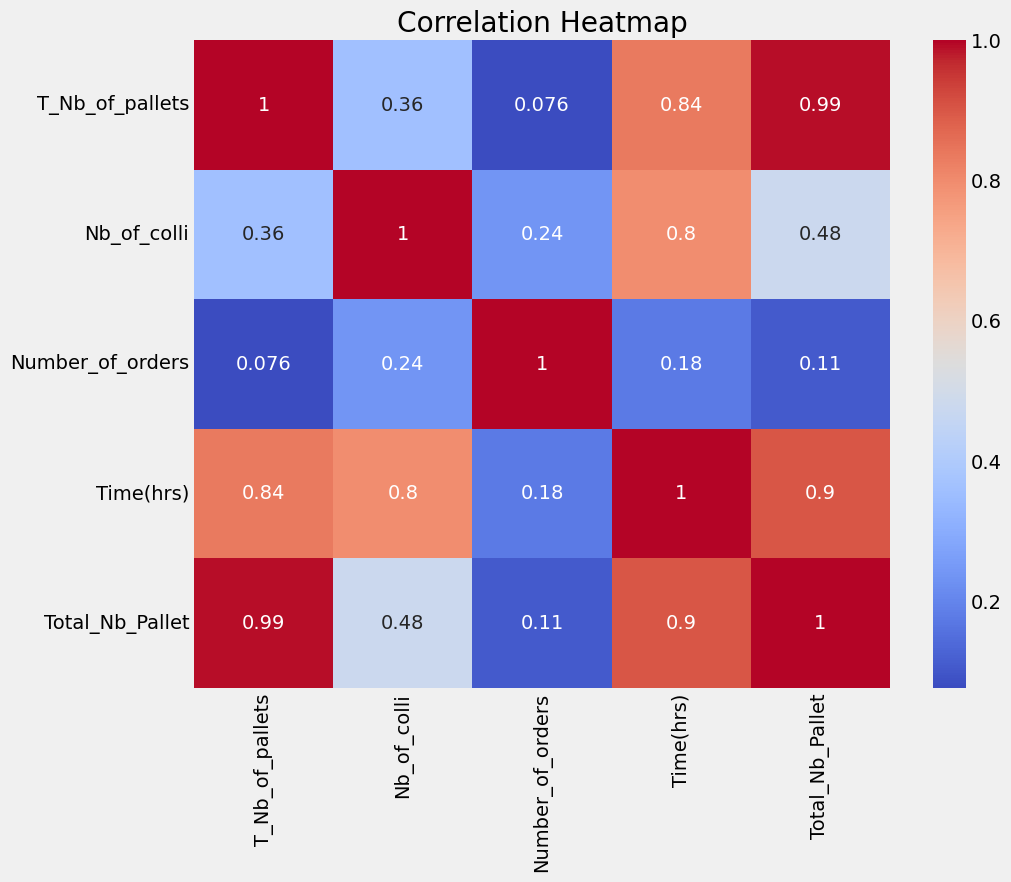

In [148]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(outbound_data[['T_Nb_of_pallets', 'Nb_of_colli', 'Number_of_orders', 'Time(hrs)', 'Total_Nb_Pallet']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



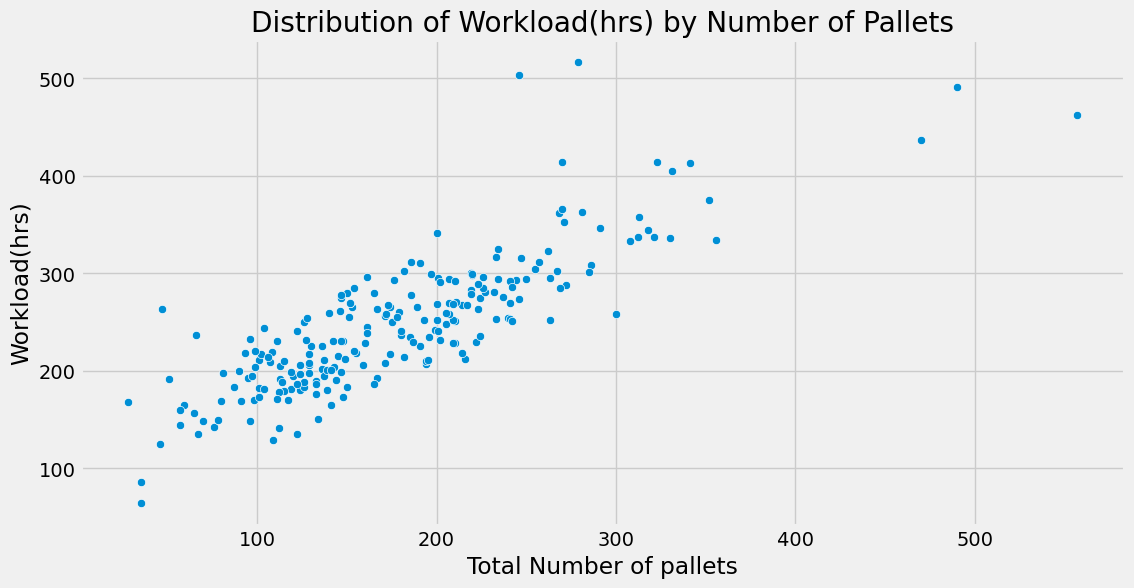

In [151]:
# Scatter Plots
plt.figure(figsize=(12, 6))
sns.scatterplot(x='T_Nb_of_pallets', y='Time(hrs)', data=outbound_data)
plt.title('Distribution of Workload(hrs) by Number of Pallets')
plt.ylabel('Workload(hrs)')
plt.xlabel('Total Number of pallets')
plt.show()



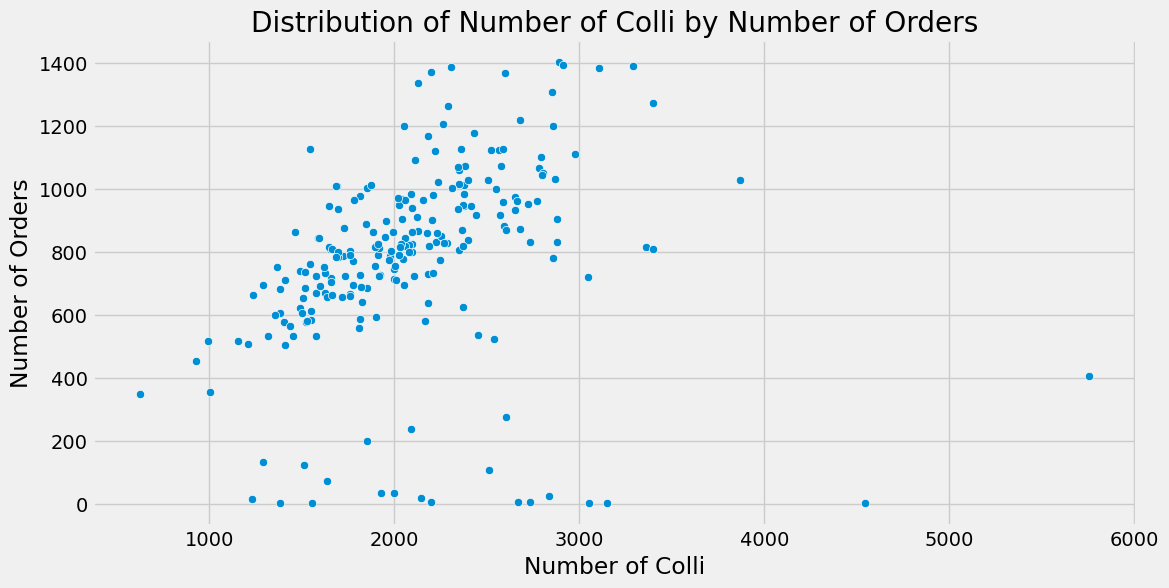

In [154]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Nb_of_colli', y='Number_of_orders', data=outbound_data)
plt.title('Distribution of Number of Colli by Number of Orders')
plt.ylabel('Number of Orders')
plt.xlabel('Number of Colli')
plt.show()



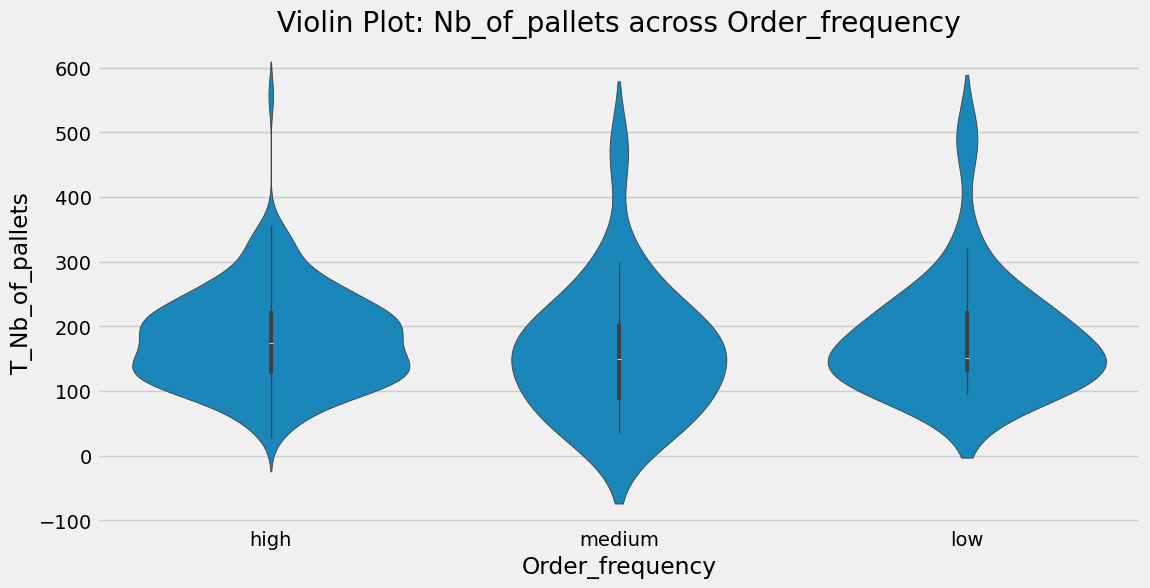

In [90]:
# Violin Plots
plt.figure(figsize=(12, 6))
sns.violinplot(x='Order_frequency', y='T_Nb_of_pallets', data=outbound_data)
plt.title('Violin Plot: Nb_of_pallets across Order_frequency')
plt.show()



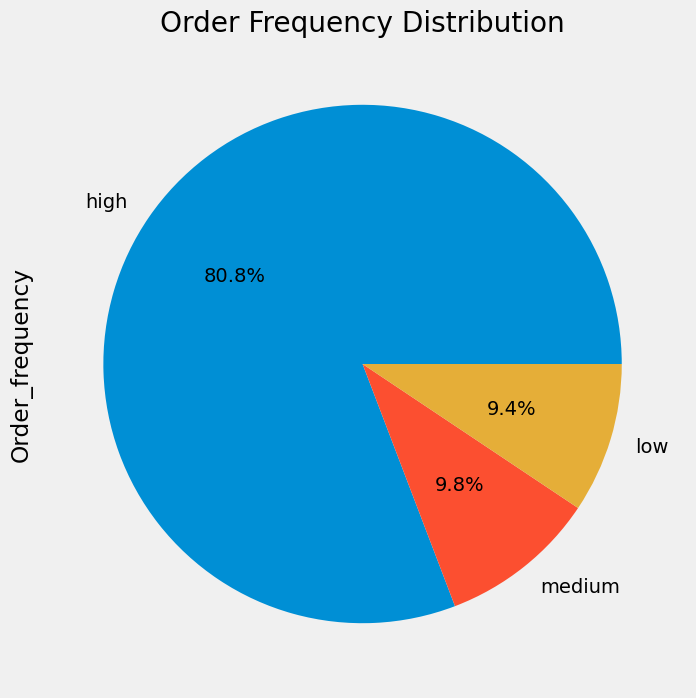

In [155]:
# Pie Chart
plt.figure(figsize=(16, 8))
outbound_data['Order_frequency'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Order Frequency Distribution')
plt.show()


C:\Users\harve\AppData\Local\Temp\ipykernel_22316\1086009184.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month_name', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette)
C:\Users\harve\AppData\Local\Temp\ipykernel_22316\1086009184.py:4: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Month_name', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette)


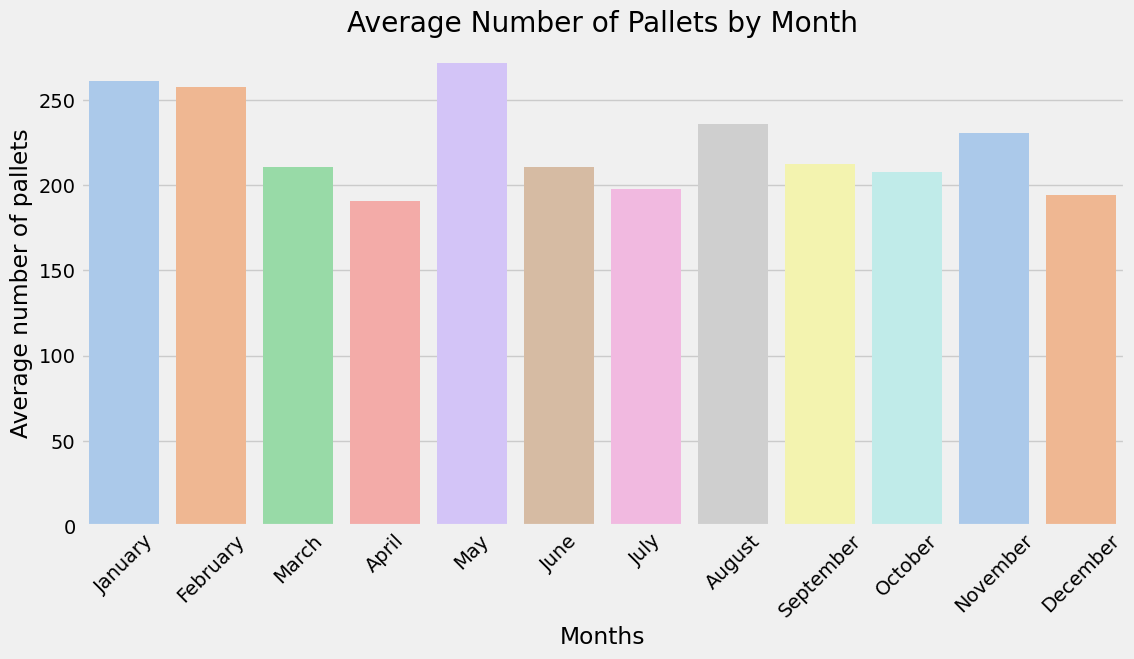

In [172]:
custom_palette = sns.color_palette("pastel")
plt.figure(figsize=(12, 6))
# sns.barplot(x='Month', y='Total_Nb_Pallet', data=outbound_data.groupby('Month')['Total_Nb_Pallet'].mean().reset_index())
sns.barplot(x='Month_name', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette)
plt.title('Average Number of Pallets by Month')
plt.xticks(rotation=45)
plt.ylabel('Average number of pallets')
plt.xlabel('Months')
plt.show()

In [8]:
# Extract additional date-related columns
# Convert 'Order_date' to datetime type
outbound_data['Order_date'] = pd.to_datetime(outbound_data['Order_date'], format='%d-%m-%Y')

# Extract additional date-related columns
outbound_data['Day_name'] = outbound_data['Order_date'].dt.strftime('%A')  # Day names
outbound_data['Month_name'] = outbound_data['Order_date'].dt.strftime('%B')  # Month names
outbound_data['Year'] = outbound_data['Order_date'].dt.year
outbound_data['Quarter'] = outbound_data['Order_date'].dt.quarter

# # Set the order of months
month_order = list(calendar.month_name)[1:]


In [161]:
# outbound_data

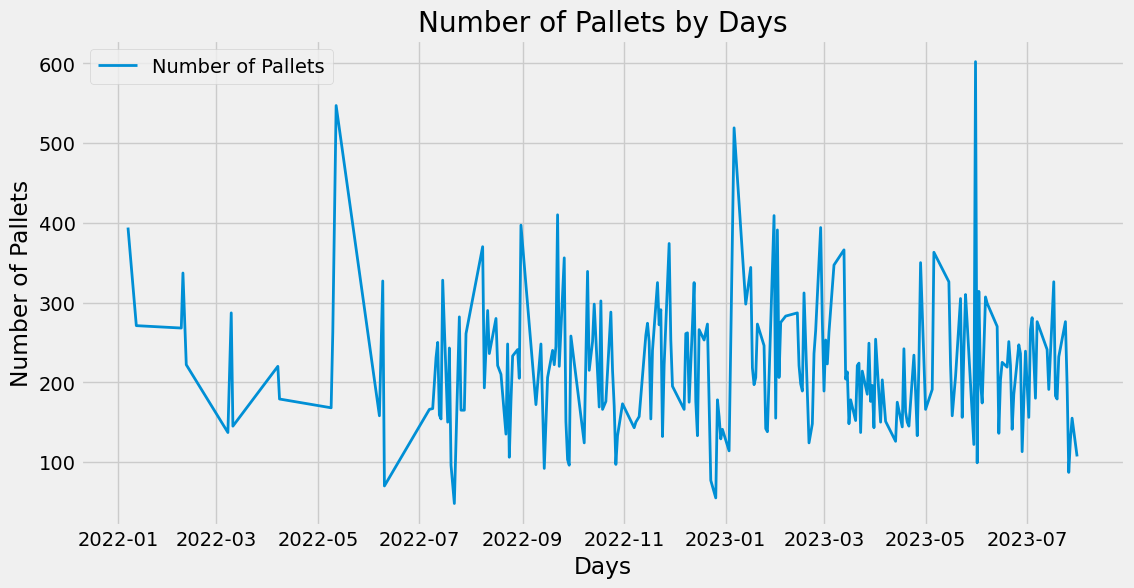

In [9]:
# Plot by days
plt.figure(figsize=(12, 6))
sns.lineplot(x='Order_date', y='Total_Nb_Pallet', data=outbound_data, label='Number of Pallets', linewidth=2)
plt.title('Number of Pallets by Days')
plt.xlabel('Days')
plt.ylabel('Number of Pallets')
# plt.xticks(rotation=45, ha='right')
plt.show()


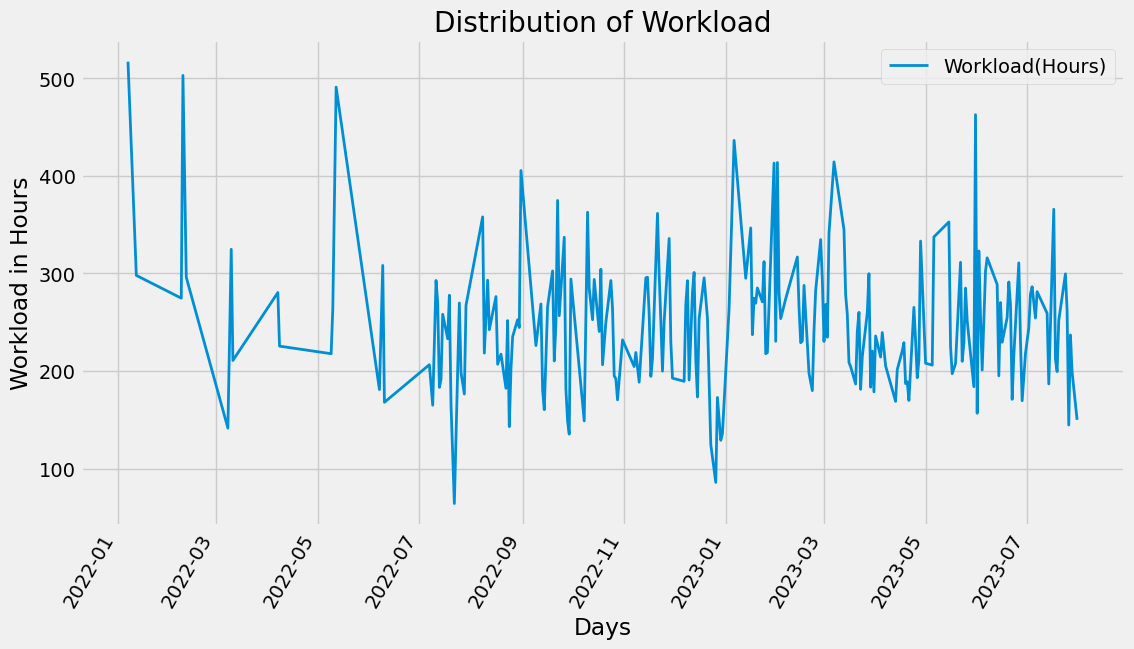

In [163]:
# Plot by days
plt.figure(figsize=(12, 6))
sns.lineplot(x='Order_date', y='Time(hrs)', data=outbound_data, label='Workload(Hours)', linewidth=2)
plt.title('Distribution of Workload')
plt.xlabel('Days')
plt.ylabel('Workload(Hours)')
plt.xticks(rotation=60, ha='right')
plt.show()

C:\Users\harve\AppData\Local\Temp\ipykernel_22316\1997931135.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Month_name', y='Total_Nb_Pallet', data=outbound_data, ci=None, hue_order=month_order, label='Number of Pallets', linewidth=2)


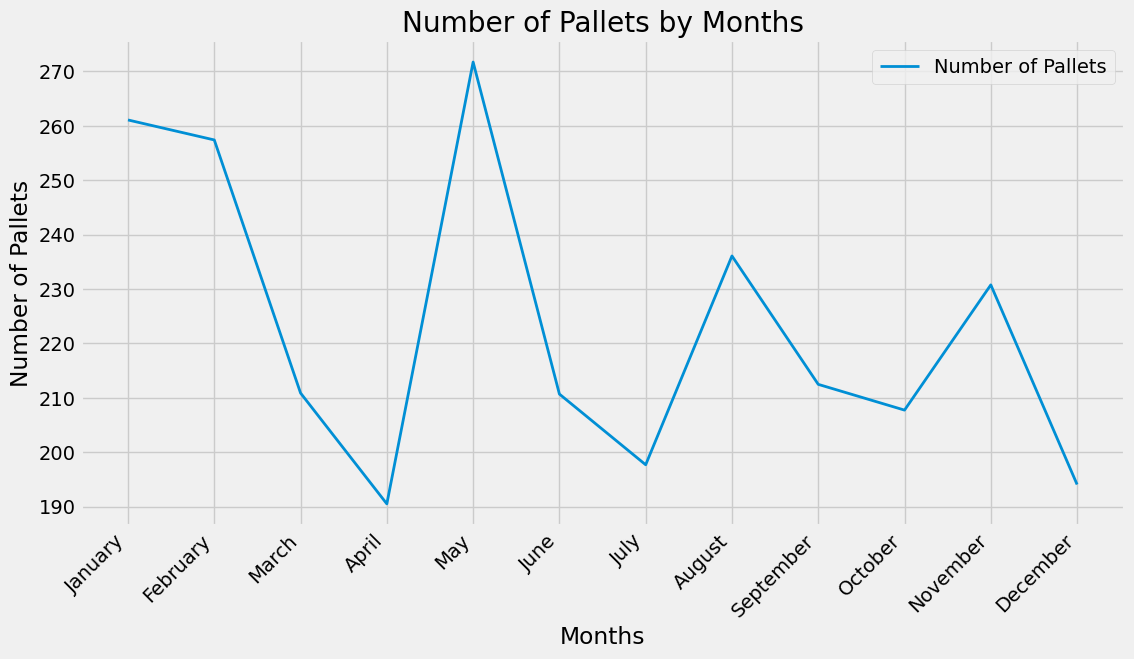

In [164]:
# Plot by months
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month_name', y='Total_Nb_Pallet', data=outbound_data, ci=None, hue_order=month_order, label='Number of Pallets', linewidth=2)
plt.title('Number of Pallets by Months')
plt.xlabel('Months')
plt.ylabel('Number of Pallets')
plt.xticks(rotation=45, ha='right')
plt.show()


C:\Users\harve\AppData\Local\Temp\ipykernel_22316\4145076712.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Quarter', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette, label='Number of Pallets', estimator=sum)
C:\Users\harve\AppData\Local\Temp\ipykernel_22316\4145076712.py:6: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(x='Quarter', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette, label='Number of Pallets', estimator=sum)


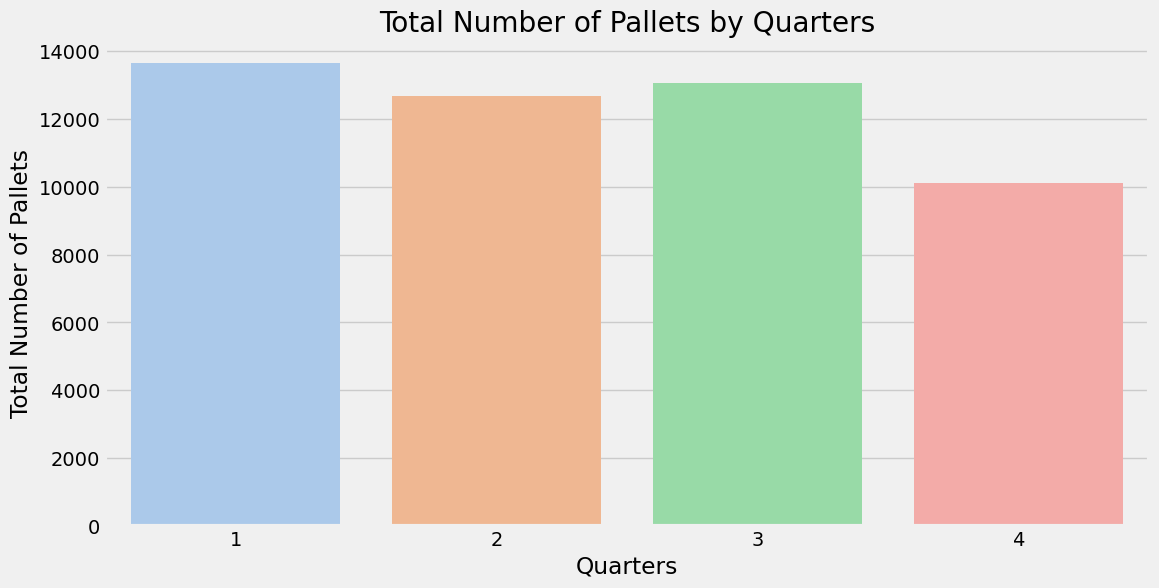

In [168]:


# Plot by quarters
custom_palette = sns.color_palette("pastel")

plt.figure(figsize=(12, 6))

sns.barplot(x='Quarter', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette, label='Number of Pallets', estimator=sum)
plt.title('Total Number of Pallets by Quarters')
plt.xlabel('Quarters')
plt.ylabel('Total Number of Pallets')
plt.show()



C:\Users\harve\AppData\Local\Temp\ipykernel_22316\3500326935.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette, label='Number of Pallets', estimator=sum)
C:\Users\harve\AppData\Local\Temp\ipykernel_22316\3500326935.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x='Year', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette, label='Number of Pallets', estimator=sum)


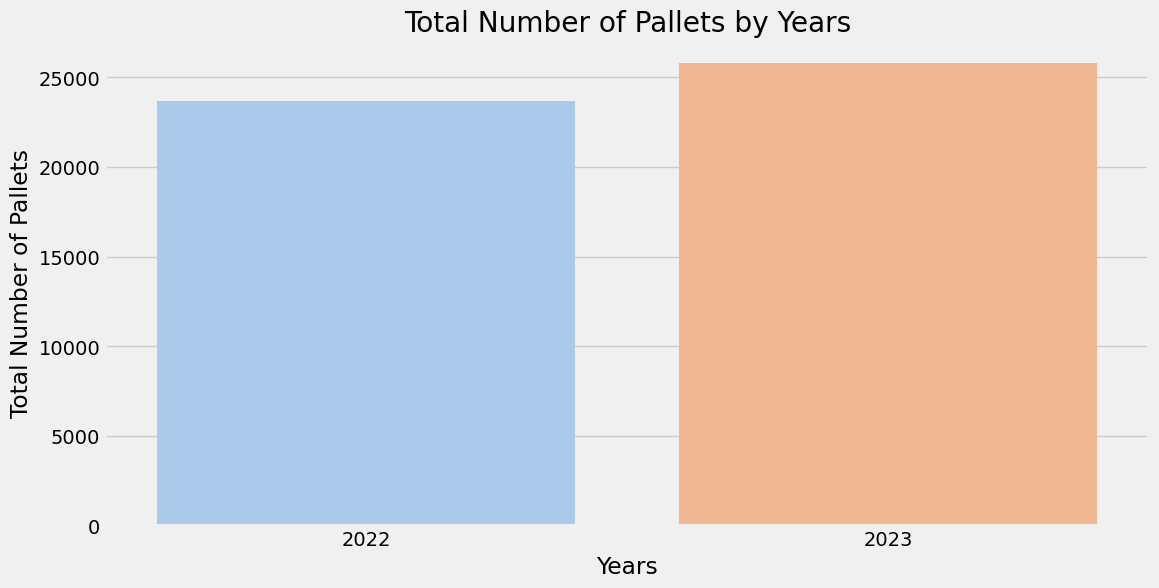

In [173]:
# Plot by years
custom_palette = sns.color_palette("pastel")

plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Total_Nb_Pallet', data=outbound_data, errorbar=None, palette=custom_palette, label='Number of Pallets', estimator=sum)
plt.title('Total Number of Pallets by Years')
plt.xlabel('Years')
plt.ylabel('Total Number of Pallets')
plt.show()

## Modeling Using XGBoost

XGBoost, which stands for eXtreme Gradient Boosting, is a powerful and popular machine learning algorithm that belongs to the gradient boosting family. It has gained widespread adoption and success in various machine learning competitions and real-world applications due to its exceptional predictive performance and versatility. Here's a short introduction to XGBoost and its motivations for your workload prediction project:

### Introduction to XGBoost:

XGBoost is based on the concept of ensemble learning, particularly gradient boosting. Gradient boosting builds a strong predictive model by combining the predictions of multiple weak models (typically decision trees) in an additive manner.

- Ensemble of Decision Trees:

XGBoost is an ensemble learning method that uses a collection of decision trees. Decision trees are trained sequentially, with each tree trying to correct the errors of the combined model from the previous trees.

- Regularization and Regularized Learning:

XGBoost introduces regularization techniques to control the complexity of the model and prevent overfitting. Regularization terms are added to the objective function, making XGBoost effective in handling complex relationships in the data.

- Handling Missing Data:

XGBoost has a built-in mechanism to handle missing values in the dataset. It learns how to best handle missing values during the training process, reducing the need for extensive data preprocessing.

- Parallel and Distributed Computing:

XGBoost is designed for efficiency, with features like parallel and distributed computing. It can make use of all available CPU cores, making it faster to train compared to traditional gradient boosting implementations.

- Feature Importance:

XGBoost provides insights into feature importance, allowing you to understand which features contribute the most to the model's predictions. This is valuable for interpretability and feature selection.


### Motivation for Workload Prediction

- Handling Nonlinear Relationships:

XGBoost is capable of capturing complex, nonlinear relationships in the data. Workload in a logistics warehouse is likely influenced by various factors, and XGBoost can model these intricate dependencies.

- Time Series Forecasting:

XGBoost can be effectively used for time series forecasting tasks, making it suitable for predicting workload over time based on historical data. It can handle temporal patterns and seasonality.

- Robust to Noisy Data:

Workload prediction datasets might contain noise and outliers. XGBoost's regularization techniques make it robust to noisy data, reducing the risk of overfitting.

- Feature Importance and Interpretability:

Understanding which factors contribute most to workload variations is crucial for warehouse optimization. XGBoost's feature importance analysis provides insights into the impact of different variables.

- Performance and Scalability:

XGBoost is known for its high predictive accuracy, and its efficiency allows it to handle large datasets. As workload prediction often involves a considerable amount of historical data, this scalability is beneficial.
In summary, XGBoost is a strong candidate for your workload prediction project due to its ability to handle complex relationships, efficiently handle large datasets, and provide insights into the importance of different features. Its effectiveness in time series forecasting further supports its suitability for predicting workload variations over time.






In [10]:
outbound_data = outbound_data.set_index('Order_date')

In [58]:
# Calculate the number of workers on average 7hrs 20mins = 7.33333
outbound_data["Number_of_workers"] = round(outbound_data['Time(hrs)']/7.33333)

In [59]:
outbound_data

,T_Nb_of_pallets,Nb_of_colli,Time(hrs),Total_Nb_Pallet,Number_of_orders,Order_frequency,Month,Day,Week,Quarter,Number_of_workers
Order_date,,,,,,,,,,,
2022-01-07,279.0,5757.0,517.05,394.0,406,medium,1,7,1,1,71.0
2022-01-12,220.0,2540.0,297.98,271.0,523,medium,1,12,2,1,41.0
2022-02-08,224.0,2201.0,274.62,268.0,8,low,2,8,6,1,37.0
2022-02-09,246.0,4543.0,502.98,337.0,3,low,2,9,6,1,69.0
2022-02-11,161.0,3050.0,296.07,222.0,2,low,2,11,6,1,40.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,146.0,2570.0,261.77,197.0,919,high,7,25,30,3,36.0
2023-07-26,57.0,1499.0,144.60,87.0,608,high,7,26,30,3,20.0
2023-07-27,66.0,3108.0,236.93,128.0,1385,high,7,27,30,3,32.0


In [11]:
train = outbound_data.loc[outbound_data.index < '2023-02-28']
test = outbound_data.loc[outbound_data.index >= '2023-03-01']

In [12]:
# Split the dataset

FEATURES = ['Month','Day','Week','Quarter',]
TARGET = 'Time(hrs)'

X_train = train[FEATURES]
y_train = train[TARGET]


X_test = test[FEATURES]
y_test = test[TARGET]

In [191]:
# X_train

In [13]:
# Model building: XGBoost Regressor
# n_estimators = number of trees the model will create
# stop = if the model doesnt improve after 50 trees

reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50)
reg.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:67.33268	validation_1-rmse:60.51917
[51]	validation_0-rmse:7.72835	validation_1-rmse:96.28979


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# First trial

reg = xgb.XGBRegressor(n_estimators = 125, early_stopping_rounds=50, learning_rate=0.1)
reg.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:72.32027	validation_1-rmse:59.01079
[49]	validation_0-rmse:28.87093	validation_1-rmse:84.77671


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=125, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
# lower the learning rate so it doesnt overfit too quickly

reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50, learning_rate=0.001)
reg.fit(X_train, y_train,
         eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:74.97388	validation_1-rmse:58.91459
[78]	validation_0-rmse:72.88090	validation_1-rmse:58.97723


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# Store feature importance in a dataframe

feat_importance = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

feat_importance

,importance
Month,0.112677
Day,0.114576
Week,0.772747
Quarter,0.000000


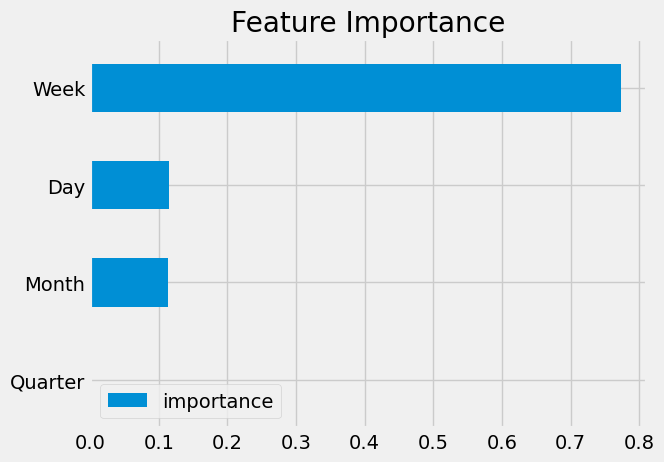

In [17]:
# Visualize on a bar plot

feat_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [18]:
# Forecast on the test dataset

test['prediction'] = reg.predict(X_test)
test

C:\Users\harve\AppData\Local\Temp\ipykernel_11664\2680262110.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


,T_Nb_of_pallets,Nb_of_colli,Time(hrs),Total_Nb_Pallet,Number_of_orders,Order_frequency,Month,Day,Week,Quarter,prediction
Order_date,,,,,,,,,,,
2023-03-01,148.0,2026.0,230.30,189.0,950,high,3,1,9,1,250.005707
2023-03-02,209.0,2180.0,268.18,253.0,638,high,3,2,9,1,250.005707
2023-03-03,185.0,1917.0,234.58,223.0,724,high,3,3,9,1,250.005707
2023-03-04,200.0,3148.0,341.03,263.0,3,low,3,4,9,1,250.005707
2023-03-07,270.0,3867.0,414.37,347.0,1027,high,3,7,10,1,250.005707
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,146.0,2570.0,261.77,197.0,919,high,7,25,30,3,248.927139
2023-07-26,57.0,1499.0,144.60,87.0,608,high,7,26,30,3,248.927139
2023-07-27,66.0,3108.0,236.93,128.0,1385,high,7,27,30,3,248.927139


In [19]:
# Merge predictions

outbound_data_plus_pred =outbound_data.merge(test[['prediction']], how='left', left_index=True, right_index=True)

outbound_data_plus_pred 

,T_Nb_of_pallets,Nb_of_colli,Time(hrs),Total_Nb_Pallet,Number_of_orders,Order_frequency,Month,Day,Week,Quarter,prediction
Order_date,,,,,,,,,,,
2022-01-07,279.0,5757.0,517.05,394.0,406,medium,1,7,1,1,NaN
2022-01-12,220.0,2540.0,297.98,271.0,523,medium,1,12,2,1,NaN
2022-02-08,224.0,2201.0,274.62,268.0,8,low,2,8,6,1,NaN
2022-02-09,246.0,4543.0,502.98,337.0,3,low,2,9,6,1,NaN
2022-02-11,161.0,3050.0,296.07,222.0,2,low,2,11,6,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,146.0,2570.0,261.77,197.0,919,high,7,25,30,3,248.927139
2023-07-26,57.0,1499.0,144.60,87.0,608,high,7,26,30,3,248.927139
2023-07-27,66.0,3108.0,236.93,128.0,1385,high,7,27,30,3,248.927139


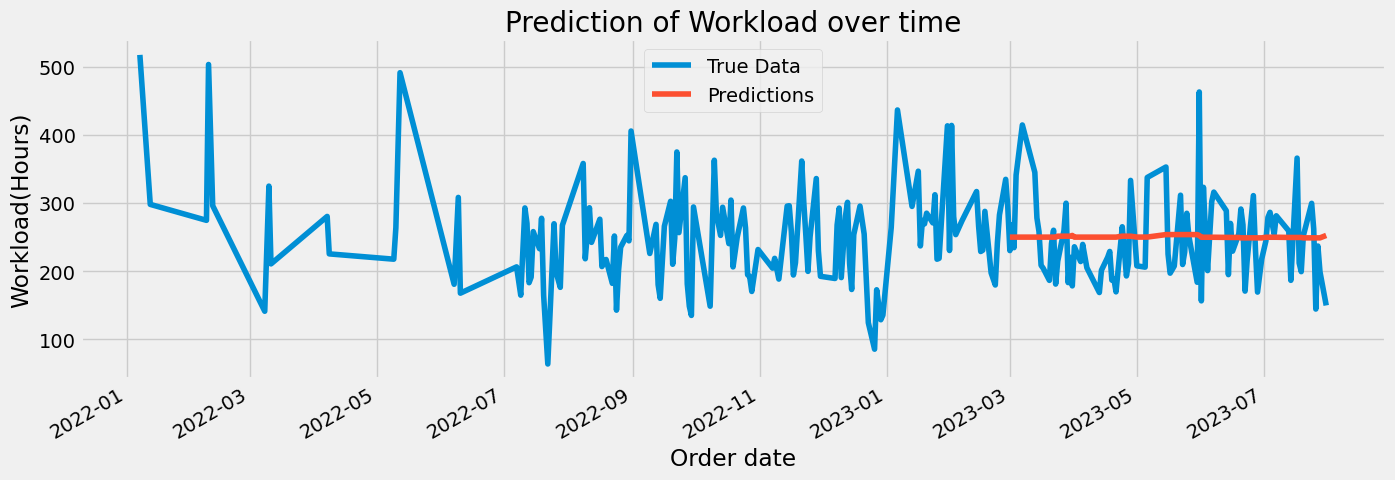

In [20]:
ax = outbound_data_plus_pred [['Time(hrs)']].plot(figsize=(15,5))
outbound_data_plus_pred['prediction'].plot(ax=ax, style='-')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.xlabel('Order date')
plt.ylabel('Workload(Hours)')
plt.title('Prediction of Workload over time')
plt.show()

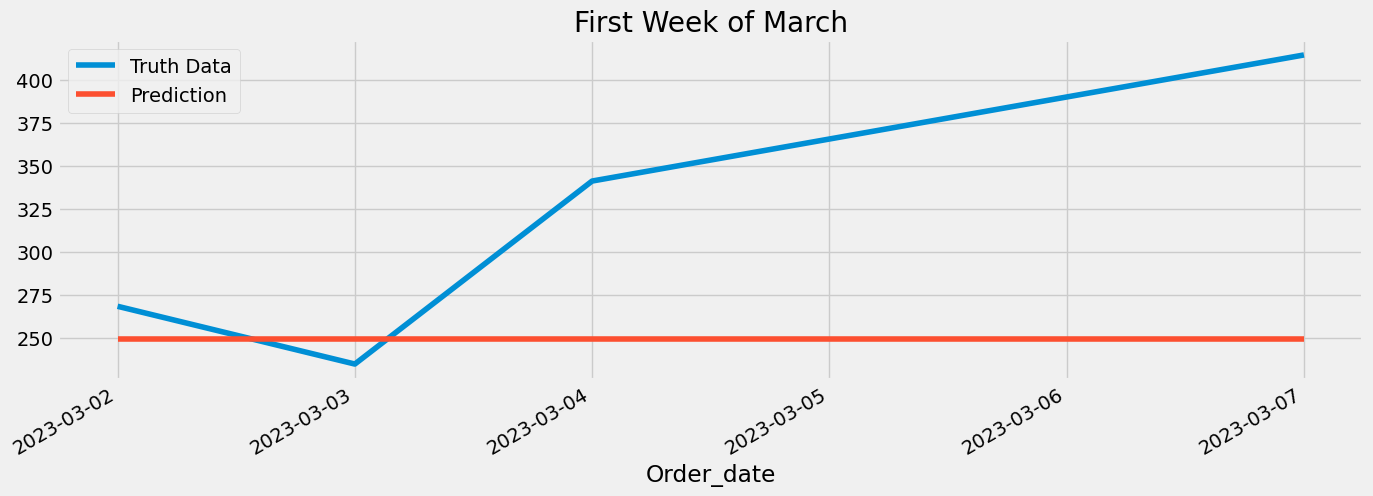

In [325]:
ax = outbound_data_plus_pred .loc[(outbound_data_plus_pred.index > '2023-03-01') & (outbound_data_plus_pred.index < '2023-03-08')]['Time(hrs)'] \
.plot(figsize=(15, 5), title='First Week of March')
outbound_data_plus_pred.loc[(outbound_data_plus_pred.index > '2023-03-01') & (outbound_data_plus_pred.index < '2023-03-08')]['prediction'] \
.plot(style='-')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [21]:
# Evaluation metric using RMSE

score = np.sqrt(mean_squared_error(test['Time(hrs)'], test['prediction']))

print(f'RMSE Score on test set: {score:0.2f}')

r2 = r2_score(test['Time(hrs)'], test['prediction'])

print(f'R-squared: {r2:.2f}')

RMSE Score on test set: 58.90
R-squared: -0.01


In [326]:
# check the worse days for prediction

test.groupby('Order_date')['error'].mean().sort_values(ascending=True).head()

Order_date
2023-05-26    2.221375
2023-07-20    3.012861
2023-07-06    4.461448
2023-06-19    5.270524
2023-07-02    5.618552
Name: error, dtype: float64

In [22]:
# Define a range of values for n_estimators
n_estimators_range = np.arange(10, 2001, 100)

# Function to perform grid search over n_estimators
def tune_n_estimators(X, y, n_estimators_range):
    param_grid = {'n_estimators': n_estimators_range}
    
    xgb_model = XGBRegressor()

    grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)

    return grid_search

# Run the function to tune n_estimators
grid_search_n_estimators = tune_n_estimators(X_train, y_train, n_estimators_range)


In [23]:
# Get the best hyperparameter values
best_n_estimators = grid_search_n_estimators.best_params_['n_estimators']

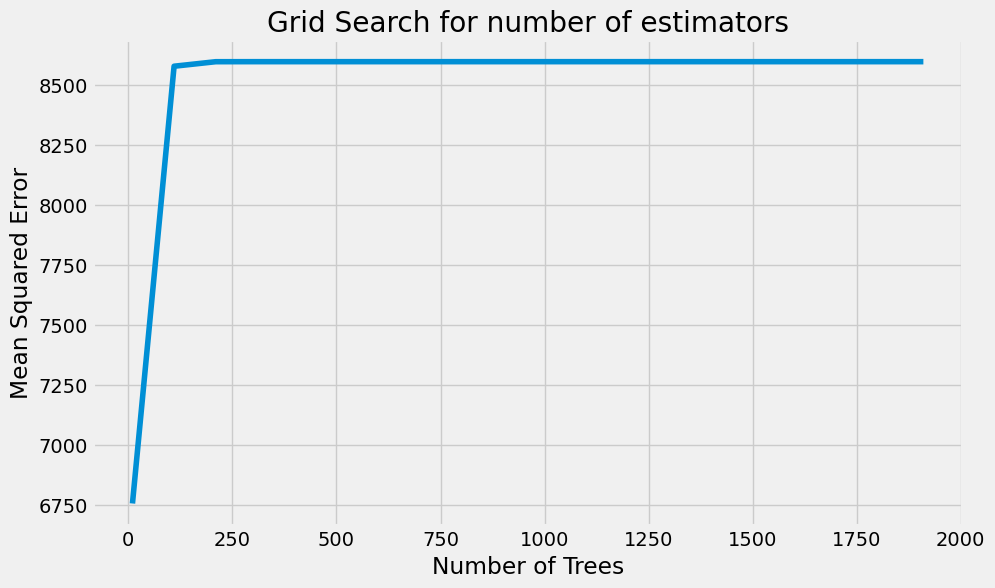

In [24]:
# Plot the values against MSE
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, -grid_search_n_estimators.cv_results_['mean_test_score'])
plt.title('Grid Search for number of estimators')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.show()

In [25]:
# Define a range of values for learning_rate
learning_rate_range = np.logspace(-5, 0, 6)

# Function to perform grid search over learning_rate
def tune_learning_rate(X, y, best_n_estimators, learning_rate_range):
    param_grid = {'learning_rate': learning_rate_range}
    
    xgb_model = XGBRegressor(n_estimators=best_n_estimators)

    grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)

    return grid_search

# Run the function to tune learning_rate
grid_search_learning_rate = tune_learning_rate(X_train, y_train, best_n_estimators, learning_rate_range)

In [26]:
# Get the best hyperparameter values
best_learning_rate = grid_search_learning_rate.best_params_['learning_rate']

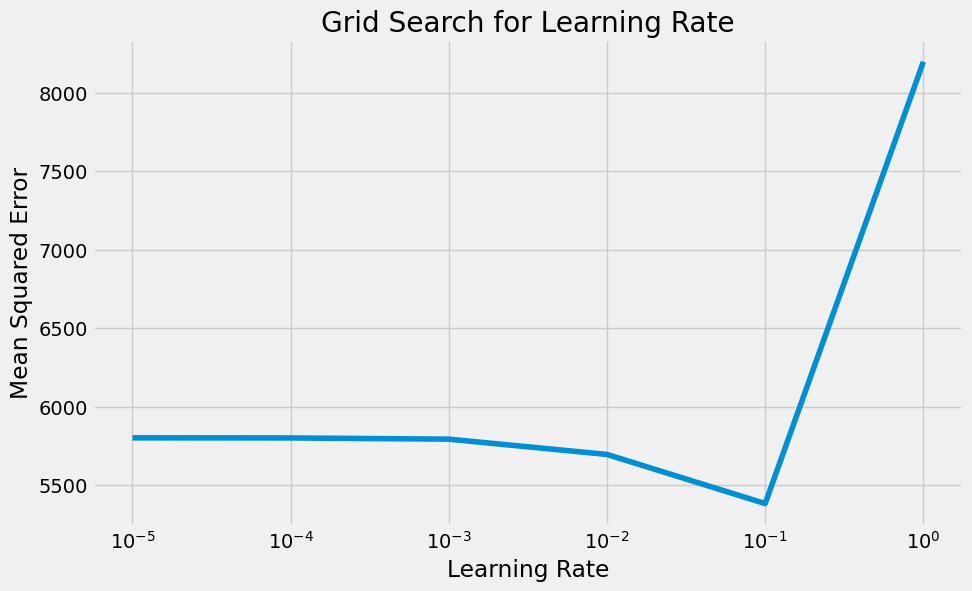

In [27]:
# Plot the values against MSE
plt.figure(figsize=(10, 6))
plt.semilogx(learning_rate_range, -grid_search_learning_rate.cv_results_['mean_test_score'])
plt.title('Grid Search for Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.show()

## Feature Engineering



In [28]:
new_feature_data = pd.get_dummies(outbound_data, columns=['Order_frequency'])
new_feature_data

,T_Nb_of_pallets,Nb_of_colli,Time(hrs),Total_Nb_Pallet,Number_of_orders,Month,Day,Week,Quarter,Order_frequency_high,Order_frequency_low,Order_frequency_medium
Order_date,,,,,,,,,,,,
2022-01-07,279.0,5757.0,517.05,394.0,406,1,7,1,1,0,0,1
2022-01-12,220.0,2540.0,297.98,271.0,523,1,12,2,1,0,0,1
2022-02-08,224.0,2201.0,274.62,268.0,8,2,8,6,1,0,1,0
2022-02-09,246.0,4543.0,502.98,337.0,3,2,9,6,1,0,1,0
2022-02-11,161.0,3050.0,296.07,222.0,2,2,11,6,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,146.0,2570.0,261.77,197.0,919,7,25,30,3,1,0,0
2023-07-26,57.0,1499.0,144.60,87.0,608,7,26,30,3,1,0,0
2023-07-27,66.0,3108.0,236.93,128.0,1385,7,27,30,3,1,0,0


In [29]:
# Split the dataset to Test and Train
train1 = new_feature_data.loc[new_feature_data.index < '2023-02-28']
test1 = new_feature_data.loc[new_feature_data.index >= '2023-03-01']

In [30]:
# Further split

FEATURES = ['Month','Week','T_Nb_of_pallets', 'Nb_of_colli','Total_Nb_Pallet', 'Number_of_orders', 'Order_frequency_high', 'Order_frequency_low', 'Order_frequency_medium']
TARGET = 'Time(hrs)'

X_train1 = train1[FEATURES]
y_train1 = train1[TARGET]


X_test1 = test1[FEATURES]
y_test1 = test1[TARGET]

In [31]:
# Second phase training

reg1 = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50, learning_rate=0.001)
reg1.fit(X_train1, y_train1,
         eval_set=[(X_train1, y_train1), (X_test1, y_test1)],
        verbose=100)

[0]	validation_0-rmse:74.93817	validation_1-rmse:58.86200


[100]	validation_0-rmse:68.93418	validation_1-rmse:53.82080
[200]	validation_0-rmse:63.46682	validation_1-rmse:49.39504
[300]	validation_0-rmse:58.47259	validation_1-rmse:45.40220
[400]	validation_0-rmse:53.91403	validation_1-rmse:41.85078
[500]	validation_0-rmse:49.74399	validation_1-rmse:38.65777
[600]	validation_0-rmse:45.92751	validation_1-rmse:35.93647
[700]	validation_0-rmse:42.43952	validation_1-rmse:33.58556
[800]	validation_0-rmse:39.25070	validation_1-rmse:31.43309
[900]	validation_0-rmse:36.32453	validation_1-rmse:29.54469
[999]	validation_0-rmse:33.61497	validation_1-rmse:27.63586


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# Level of importance

feat_importance1 = pd.DataFrame(data=reg1.feature_importances_,
             index=reg1.feature_names_in_,
             columns=['importance'])

feat_importance1

,importance
Month,0.002476
Week,0.003516
T_Nb_of_pallets,0.010907
Nb_of_colli,0.057207
Total_Nb_Pallet,0.838377
Number_of_orders,0.028710
Order_frequency_high,0.000000
Order_frequency_low,0.000000
Order_frequency_medium,0.058806


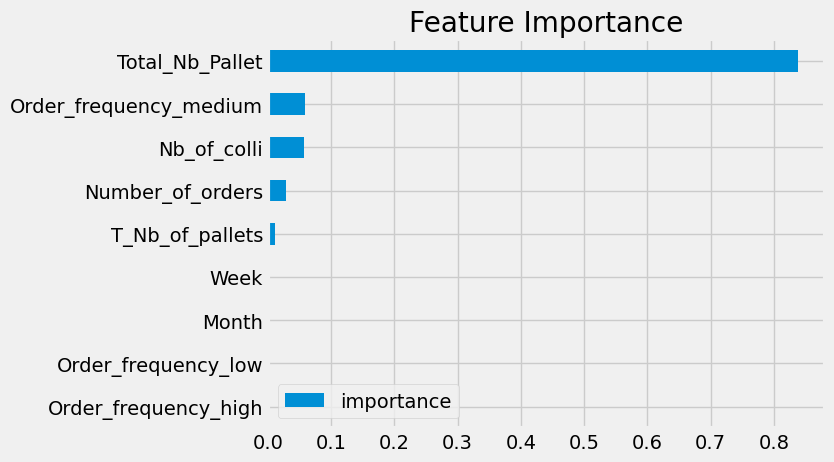

In [30]:
# Plot the important features

feat_importance1.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [34]:
# Check the prediction

test1['prediction'] = reg1.predict(X_test1)
# test1

C:\Users\harve\AppData\Local\Temp\ipykernel_11664\1313058630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['prediction'] = reg1.predict(X_test1)


In [35]:
# Merge the new prediction to the dataframe

new_feature_data_pred =new_feature_data.merge(test1[['prediction']], how='left', left_index=True, right_index=True)
new_feature_data_pred

,T_Nb_of_pallets,Nb_of_colli,Time(hrs),Total_Nb_Pallet,Number_of_orders,Month,Day,Week,Quarter,Order_frequency_high,Order_frequency_low,Order_frequency_medium,prediction
Order_date,,,,,,,,,,,,,
2022-01-07,279.0,5757.0,517.05,394.0,406,1,7,1,1,0,0,1,NaN
2022-01-12,220.0,2540.0,297.98,271.0,523,1,12,2,1,0,0,1,NaN
2022-02-08,224.0,2201.0,274.62,268.0,8,2,8,6,1,0,1,0,NaN
2022-02-09,246.0,4543.0,502.98,337.0,3,2,9,6,1,0,1,0,NaN
2022-02-11,161.0,3050.0,296.07,222.0,2,2,11,6,1,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,146.0,2570.0,261.77,197.0,919,7,25,30,3,1,0,0,262.785583
2023-07-26,57.0,1499.0,144.60,87.0,608,7,26,30,3,1,0,0,185.028427
2023-07-27,66.0,3108.0,236.93,128.0,1385,7,27,30,3,1,0,0,247.002655


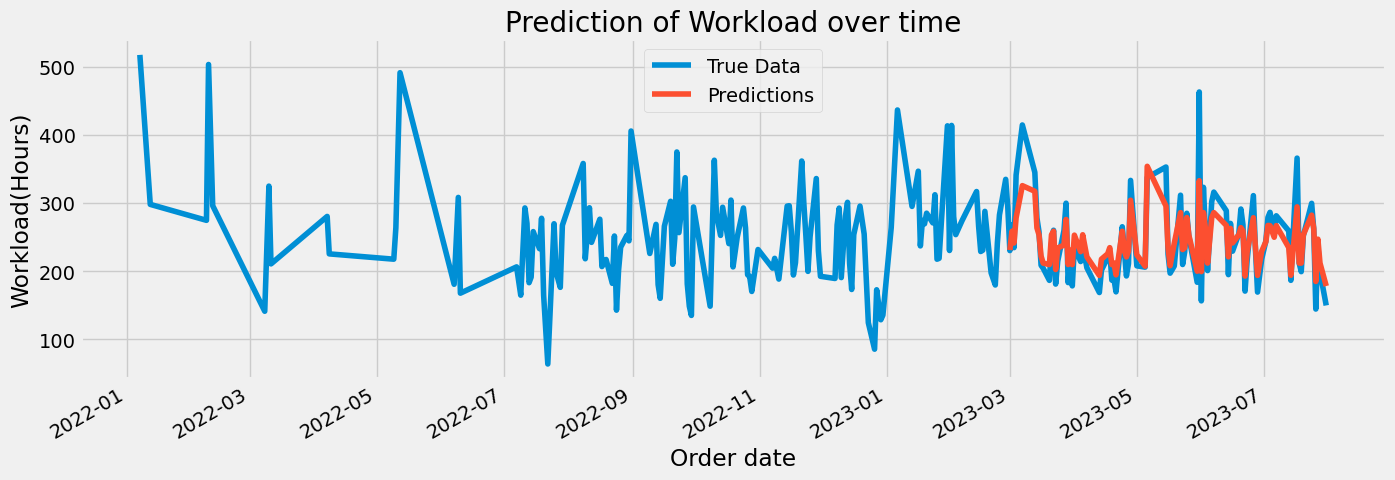

In [36]:
# Plot the prediction

ax1 = new_feature_data_pred[['Time(hrs)']].plot(figsize=(15,5))
new_feature_data_pred['prediction'].plot(ax=ax1, style='-')
plt.legend(['True Data', 'Predictions'])
ax1.set_title('Raw Data and Prediction')
plt.xlabel('Order date')
plt.ylabel('Workload(Hours)')
plt.title('Prediction of Workload over time')
plt.show()

In [37]:
# Evaluate the new model

score = np.sqrt(mean_squared_error(test1['Time(hrs)'], test1['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')
# Calculate R-squared
r2 = r2_score(test1['Time(hrs)'], test1['prediction'])
print(f'R-squared: {r2:.2f}')

RMSE Score on test set: 27.64
R-squared: 0.78


## Hyperparameter Tuning

In [317]:
## Hyperparameter Tuning

n_estimators_range = np.arange(10, 2001, 100)

# Function to perform grid search over n_estimators
def tune_n_estimators(X, y, n_estimators_range):
    param_grid = {'n_estimators': n_estimators_range}
    
    xgb_model = XGBRegressor()

    grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)

    return grid_search

# Run the function to tune n_estimators
grid_search_n_estimators = tune_n_estimators(X_train1, y_train1, n_estimators_range)


In [ ]:
# Get the best hyperparameter values
best_n_estimators = grid_search_n_estimators.best_params_['n_estimators']

In [ ]:
# Plot the values against MSE
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, -grid_search_n_estimators.cv_results_['mean_test_score'])
plt.title('Grid Search for number of estimators')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.show()


In [ ]:

# Define a range of values for learning_rate
learning_rate_range = np.logspace(-5, 0, 6)

# Function to perform grid search over learning_rate
def tune_learning_rate(X, y, best_n_estimators, learning_rate_range):
    param_grid = {'learning_rate': learning_rate_range}
    
    xgb_model = XGBRegressor(n_estimators=best_n_estimators)

    grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)

    return grid_search

# Run the function to tune learning_rate
grid_search_learning_rate = tune_learning_rate(X_train1, y_train1, best_n_estimators, learning_rate_range)

In [ ]:
# Get the best hyperparameter values
best_learning_rate = grid_search_learning_rate.best_params_['learning_rate']

In [ ]:
# Plot the values against MSE
plt.figure(figsize=(10, 6))
plt.semilogx(learning_rate_range, -grid_search_learning_rate.cv_results_['mean_test_score'])
plt.title('Grid Search for Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.show()

In [38]:
# Second phase training

reg1 = xgb.XGBRegressor(n_estimators = 125, early_stopping_rounds=50, learning_rate=0.1)
reg1.fit(X_train1, y_train1,
         eval_set=[(X_train1, y_train1), (X_test1, y_test1)],
        verbose=100)

[0]	validation_0-rmse:68.72113	validation_1-rmse:53.56473
[100]	validation_0-rmse:0.79946	validation_1-rmse:17.21475
[103]	validation_0-rmse:0.74285	validation_1-rmse:17.21619


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=125, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [39]:
# Check the prediction

test1['prediction'] = reg1.predict(X_test1)
# test1

C:\Users\harve\AppData\Local\Temp\ipykernel_11664\1313058630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['prediction'] = reg1.predict(X_test1)


In [40]:
# Merge the new prediction to the dataframe

new_feature_data_pred =new_feature_data.merge(test1[['prediction']], how='left', left_index=True, right_index=True)
new_feature_data_pred

,T_Nb_of_pallets,Nb_of_colli,Time(hrs),Total_Nb_Pallet,Number_of_orders,Month,Day,Week,Quarter,Order_frequency_high,Order_frequency_low,Order_frequency_medium,prediction
Order_date,,,,,,,,,,,,,
2022-01-07,279.0,5757.0,517.05,394.0,406,1,7,1,1,0,0,1,NaN
2022-01-12,220.0,2540.0,297.98,271.0,523,1,12,2,1,0,0,1,NaN
2022-02-08,224.0,2201.0,274.62,268.0,8,2,8,6,1,0,1,0,NaN
2022-02-09,246.0,4543.0,502.98,337.0,3,2,9,6,1,0,1,0,NaN
2022-02-11,161.0,3050.0,296.07,222.0,2,2,11,6,1,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,146.0,2570.0,261.77,197.0,919,7,25,30,3,1,0,0,268.020599
2023-07-26,57.0,1499.0,144.60,87.0,608,7,26,30,3,1,0,0,142.556793
2023-07-27,66.0,3108.0,236.93,128.0,1385,7,27,30,3,1,0,0,239.023346


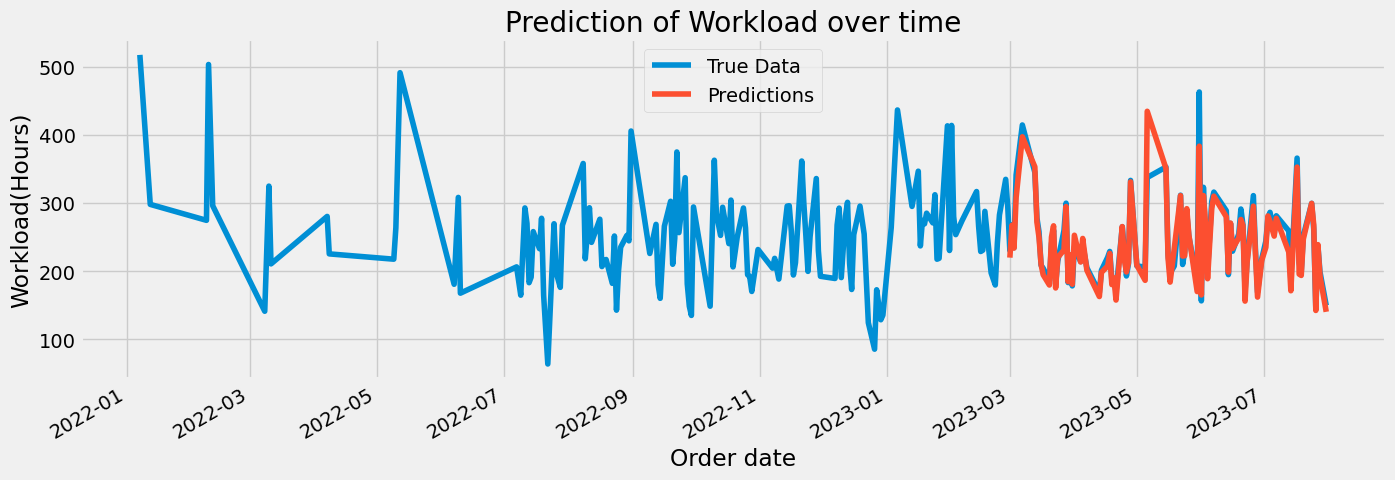

In [41]:
# Plot the prediction

ax1 = new_feature_data_pred[['Time(hrs)']].plot(figsize=(15,5))
new_feature_data_pred['prediction'].plot(ax=ax1, style='-')
plt.legend(['True Data', 'Predictions'])
ax1.set_title('Raw Data and Prediction')
plt.xlabel('Order date')
plt.ylabel('Workload(Hours)')
plt.title('Prediction of Workload over time')
plt.show()

In [55]:
# Calculate the residuals (difference between true values and predictions)
residuals = new_feature_data_pred['Time(hrs)'] - new_feature_data_pred['prediction']

# Calculate the mean squared error (MSE)
mse = np.mean(residuals**2)

# Calculate the standard deviation of predictions
prediction_std = np.sqrt(mse)

# Set the confidence level
confidence_level = 0.95

# Calculate the margin of error
margin_of_error = prediction_std * 1.96

# Calculate lower and upper bounds
lower_bound = new_feature_data_pred['prediction'] - margin_of_error
upper_bound = new_feature_data_pred['prediction'] + margin_of_error

# Add the lower and upper bounds to the DataFrame
new_feature_data_pred['lower_bound'] = lower_bound
new_feature_data_pred['upper_bound'] = upper_bound


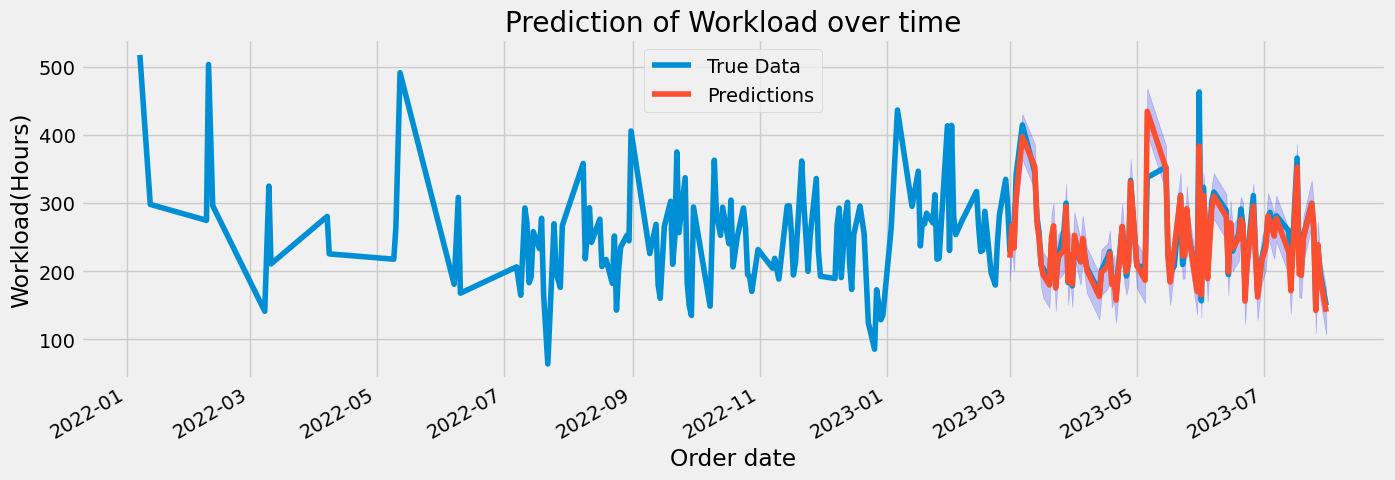

In [57]:
# Plot the data and predictions with confidence interval
ax1 = new_feature_data_pred[['Time(hrs)']].plot(figsize=(15, 5))
new_feature_data_pred['prediction'].plot(ax=ax1, style='-')

# Plot confidence interval
plt.fill_between(new_feature_data_pred.index, lower_bound, upper_bound, color='blue', alpha=0.2)

plt.legend(['True Data', 'Predictions'])
ax1.set_title('Raw Data and Prediction')
plt.xlabel('Order date')
plt.ylabel('Workload(Hours)')
plt.title('Prediction of Workload over time')
plt.show()

In [46]:
# Evaluate the new model

score = np.sqrt(mean_squared_error(test1['Time(hrs)'], test1['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')
# Calculate R-squared
r2 = r2_score(test1['Time(hrs)'], test1['prediction'])
r2 = r2*100
print(f'R-squared: {r2:.2f}')

RMSE Score on test set: 17.07
R-squared: 91.50


## Model Comparison

In [ ]:
# Calculate MSE for each model
mse_rf = mean_squared_error(actual, predicted_rf)
mse_xgb = mean_squared_error(actual, predicted_xgb)
mse_arima = mean_squared_error(actual, predicted_arima)
mse_var = mean_squared_error(actual, predicted_var)
mse_garch = mean_squared_error(actual, predicted_garch)

# Create a DataFrame for visualization
data = {
    'Model': ['Random Forest', 'XGBoost', 'ARIMA', 'VAR', 'GARCH'],
    'MSE': [mse_rf, mse_xgb, mse_arima, mse_var, mse_garch]
}

df_mse = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 8))

# Line plot for MSE comparison
sns.lineplot(x='Model', y='MSE', data=df_mse, marker='o', label='MSE')

# Customize the plot
plt.title('Mean Squared Error Comparison')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [17]:
# Using Hyperopt for optimization (Hyperparameter tuning)
def xgb_mse_cv(params, random_state=None, cv=None, X=None, y=None):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
    }

    model = xgb.XGBRegressor(random_state=random_state, **params)

    score = -cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1).mean()

    return score


In [26]:
# Set random state and other parameters
random_state = np.random.randint(2**31 - 1)
n_iter = 50  # Number of optimization iterations

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 2000, 1),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0)
}

# Trials will contain logging information
trials = Trials()

# Run optimization
best = fmin(fn=lambda params: xgb_mse_cv(params, random_state=random_state, cv=5, X=X_train1, y=y_train1),
            space=space,
            algo=tpe.suggest,
            max_evals=n_iter,
            trials=trials,
            rstate=random_state
)

# Computing the score on the test set
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
}

model = xgb.XGBRegressor(random_state=random_state, **best_params)
model.fit(X_train1, y_train1)
test_score = mean_squared_error(X_test1, model.predict(y_test1))

print("Best MSE {:.3f} with params {}".format(-trials.best_trial['result']['loss'], best_params))
print("Test MSE {:.3f}".format(test_score))


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

AttributeError: 'int' object has no attribute 'integers'

## Regularization

In [ ]:
# Regularization



## Ensemble Method
- Combine XGBoost and Random Forest
- Combine XGBoost and AdaBoost
- Combine AdaBoost and Random Forest

In [ ]:
# Ensemble Method